Model: "PSR_Enhancement_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ IIRS_input (InputLayer)   │ (None, 64, 64, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ OHRC_input (InputLayer)   │ (None, 64, 64, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ shared_encoder            │ (None, 4096, 1)        │     68,217,536 │ OHRC_input[0][0],      │
│ (Functional)              │                        │                │ IIRS_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_4 (Attention)   │ (None, 4096, 1)        │              0 │ shared_encoder[1][0],  │
│                           │                        │                │ shared_encoder[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 4096, 1)        │              0 │ shared_encoder[1][0],  │
│                           │                        │                │ attention_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder (Functional)      │ (None, 64, 64, 1)      │         19,393 │ add_2[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 68,236,929 (260.30 MB)

 Trainable params: 68,236,929 (260.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - loss: 0.0828 - mae: 0.2488
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - loss: 0.0824 - mae: 0.2484
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - loss: 0.0824 - mae: 0.2484
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - loss: 0.0825 - mae: 0.2483
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - loss: 0.0824 - mae: 0.2483
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


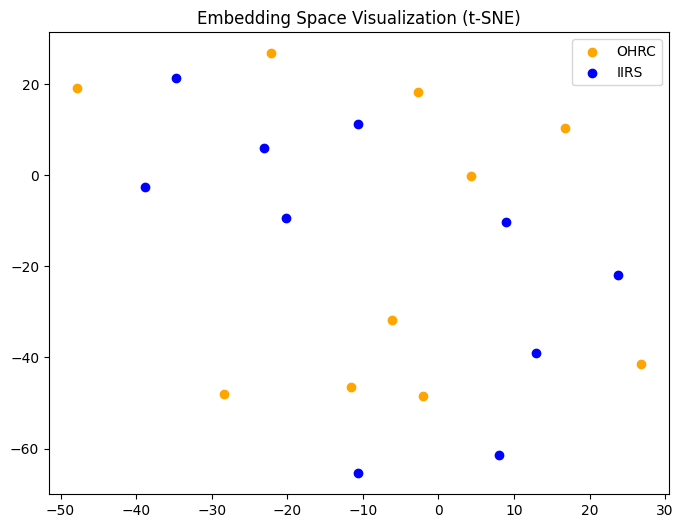

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Enhanced Images Shape: (10, 64, 64, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Add, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# Define the shared encoder
def shared_encoder(input_shape):
    inputs = Input(shape=input_shape)

    # Convolutional layers for feature extraction
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Flatten()(x)  # Flatten to 1D
    x = Dense(256, activation='relu')(x)  # Dense layer

    outputs = Dense(64 * 64, activation='relu')(x)  # Output flattened latent space
    outputs = Reshape((64 * 64, 1))(outputs)  # Reshape for Attention

    return Model(inputs, outputs, name='shared_encoder')

# Attention mechanism to combine embeddings
def attention_combiner(structural_embeddings, resolution_embeddings):
    # Input: [batch_size, sequence_length, features]
    attention = Attention()([structural_embeddings, resolution_embeddings])
    combined = Add()([structural_embeddings, attention])
    return combined

# Define the decoder
def decoder(input_shape):
    inputs = Input(shape=input_shape)

    # Reshape inputs back to 2D
    x = Reshape((64, 64, 1))(inputs)

    # Upsampling and convolutional layers to reconstruct the image
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    return Model(inputs, x, name='decoder')

# Image enhancement model
def create_enhancement_model(input_shape):
    # Shared encoder for both OHRC and IIRS images
    encoder = shared_encoder(input_shape)

    # Inputs for OHRC and IIRS images
    ohrc_input = Input(shape=input_shape, name='OHRC_input')
    iirs_input = Input(shape=input_shape, name='IIRS_input')

    # Extract embeddings
    ohrc_embeddings = encoder(ohrc_input)  # Shape: [batch_size, sequence_length, 1]
    iirs_embeddings = encoder(iirs_input)

    # Combine embeddings using the attention mechanism
    combined_embeddings = attention_combiner(iirs_embeddings, ohrc_embeddings)

    # Pass combined embeddings through the decoder
    decoder_model = decoder((64 * 64, 1))
    enhanced_output = decoder_model(combined_embeddings)

    return Model(inputs=[ohrc_input, iirs_input], outputs=enhanced_output, name='PSR_Enhancement_Model')

# Data preparation (dummy data for demonstration purposes)
def generate_dummy_data(num_samples, input_shape):
    # Simulate OHRC and IIRS images with random values
    ohrc_images = np.random.rand(num_samples, *input_shape).astype(np.float32)
    iirs_images = np.random.rand(num_samples, *input_shape).astype(np.float32)
    target_images = np.random.rand(num_samples, *input_shape).astype(np.float32)
    return ohrc_images, iirs_images, target_images

# Visualization of embeddings using t-SNE
def visualize_embeddings(encoder, ohrc_images, iirs_images):
    ohrc_embeddings = encoder.predict(ohrc_images)
    iirs_embeddings = encoder.predict(iirs_images)

    # Flatten embeddings
    ohrc_flat = ohrc_embeddings.reshape((ohrc_embeddings.shape[0], -1))
    iirs_flat = iirs_embeddings.reshape((iirs_embeddings.shape[0], -1))

    # Combine embeddings for visualization
    embeddings = np.vstack((ohrc_flat, iirs_flat))
    labels = ['OHRC'] * len(ohrc_flat) + ['IIRS'] * len(iirs_flat)

    # Reduce dimensions using t-SNE
    tsne = TSNE(n_components=2, perplexity=5, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_embeddings[:len(ohrc_flat), 0], reduced_embeddings[:len(ohrc_flat), 1], label='OHRC', color='orange')
    plt.scatter(reduced_embeddings[len(ohrc_flat):, 0], reduced_embeddings[len(ohrc_flat):, 1], label='IIRS', color='blue')
    plt.title("Embedding Space Visualization (t-SNE)")
    plt.legend()
    plt.show()

# Train the model
def train_model(model, ohrc_images, iirs_images, target_images):
    model.compile(optimizer=Adam(1e-4), loss='mean_squared_error', metrics=['mae'])
    model.fit([ohrc_images, iirs_images], target_images, epochs=5, batch_size=2)

# Main function to run the complete pipeline
def main():
    input_shape = (64, 64, 1)
    num_samples = 10  # Example dataset size

    # Generate dummy data
    ohrc_images, iirs_images, target_images = generate_dummy_data(num_samples, input_shape)

    # Create and train the model
    model = create_enhancement_model(input_shape)
    model.summary()
    train_model(model, ohrc_images, iirs_images, target_images)

    # Visualize embeddings
    encoder = shared_encoder(input_shape)
    visualize_embeddings(encoder, ohrc_images, iirs_images)

    # Predict on new data
    enhanced_images = model.predict([ohrc_images, iirs_images])
    print("Enhanced Images Shape:", enhanced_images.shape)

if __name__ == "__main__":
    main()


# KAAM KA CODE

# Image Preprocessing

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, UpSampling2D, Attention
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from skimage.metrics import structural_similarity as ssim

# Define Dataset Paths
ohrc_image_path = "/content/drive/MyDrive/data_sci/ohrc"
iirs_image_path = "/content/drive/MyDrive/data_sci/iirs"
output_dir = "/content/drive/MyDrive/data_sci/Output image"
final_enhanced_dir = "/content/drive/MyDrive/data_sci/final_enhanced-image"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(final_enhanced_dir, exist_ok=True)

# 1. Image Preprocessing
def preprocess_images(image_path, img_size=(256, 256)):
    images = []
    for file in os.listdir(image_path):
        img = cv2.imread(os.path.join(image_path, file))
        if img is not None:
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize to [0, 1]
            images.append(img)
    return np.array(images)

# Load Images
ohrc_images = preprocess_images(ohrc_image_path)
iirs_images = preprocess_images(iirs_image_path)

print("OHRC Images Shape:", ohrc_images.shape)
print("IIRS Images Shape:", iirs_images.shape)

OHRC Images Shape: (2, 256, 256, 3)
IIRS Images Shape: (3, 256, 256, 3)


# shared Encoder ( Embeddings )

In [ ]:
# 2. Shared Encoder with Structural and Resolution Embeddings
def build_shared_encoder(input_shape=(256, 256, 3)):
    input_layer = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    # Structural Embeddings
    structural_branch = Flatten()(x)
    structural_embedding = Dense(128, activation='relu', name="structural_embedding")(structural_branch)

    # Resolution Embeddings
    resolution_branch = Flatten()(x)
    resolution_embedding = Dense(128, activation='relu', name="resolution_embedding")(resolution_branch)

    model = Model(inputs=input_layer, outputs=[structural_embedding, resolution_embedding])
    return model

shared_encoder = build_shared_encoder()
shared_encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 32)   │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 262144)         │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 262144)         │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ structural_embedding      │ (None, 128)            │     33,554,560 │ flatten[0][0]          │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resolution_embedding      │ (None, 128)            │     33,554,560 │ flatten_1[0][0]        │
│ (Dense)                   │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 67,128,512 (256.07 MB)

 Trainable params: 67,128,512 (256.07 MB)

 Non-trainable params: 0 (0.00 B)

# Defining Generator and Discriminator

In [ ]:
# 3. Attention Layer
def attention_layer(inputs):
    query, value = inputs
    attn = Attention()([query, value])
    return attn

# 4. Generator and Discriminator
def build_generator():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))  # Output: 3-channel image
    return model

def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 6)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))  # Real or Fake
    return model

# Define and Compile Models
generator = build_generator()
discriminator = build_discriminator()

discriminator.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(256, 256, 3))
    enhanced_image = generator(gan_input)
    gan_output = discriminator(concatenate([gan_input, enhanced_image]))
    gan = Model(inputs=gan_input, outputs=gan_output)
    return gan

gan = build_gan(generator, discriminator)
gan.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy')

print("Generator:")
generator.summary()
print("Discriminator:")
discriminator.summary()

Generator:


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 256, 256, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 256, 256, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,123 (82.51 KB)

 Trainable params: 21,123 (82.51 KB)

 Non-trainable params: 0 (0.00 B)

Discriminator:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 256, 256, 64)        │           3,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1048576)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │       1,048,577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,052,097 (4.01 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,052,097 (4.01 MB)

# Training

In [ ]:
# 5. Training Loop
X = ohrc_images  # Input images
Y = iirs_images  # Target images for conditional GAN

epochs = 10
batch_size = min(16, min(len(X), len(Y)))

for epoch in range(epochs):
    num_batches = len(X) // batch_size
    epoch_d_loss, epoch_g_loss = 0, 0

    for batch in range(num_batches):
        start_idx = batch * batch_size
        end_idx = start_idx + batch_size
        real_images = X[start_idx:end_idx]
        target_images = Y[start_idx:end_idx]

        # Generate Fake Images
        fake_images = generator.predict(real_images)

        # Train Discriminator
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))
        d_loss_real = discriminator.train_on_batch(np.concatenate([real_images, target_images], axis=-1), real_labels)
        d_loss_fake = discriminator.train_on_batch(np.concatenate([real_images, fake_images], axis=-1), fake_labels)
        d_loss = 0.5 * (d_loss_real[0] + d_loss_fake[0])

        # Train Generator
        g_loss = gan.train_on_batch(real_images, real_labels)

        # Extract the loss value from the list
        epoch_g_loss += g_loss[0]  # Access the first element (loss)

        epoch_d_loss += d_loss

    print(f"Epoch {epoch+1}/{epochs} | D Loss: {epoch_d_loss/num_batches:.4f} | G Loss: {epoch_g_loss/num_batches:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 1/10 | D Loss: 0.6708 | G Loss: 0.6784
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Epoch 2/10 | D Loss: 0.6759 | G Loss: 0.6785
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
Epoch 3/10 | D Loss: 0.6770 | G Loss: 0.6786
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Epoch 4/10 | D Loss: 0.6775 | G Loss: 0.6787
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Epoch 5/10 | D Loss: 0.6779 | G Loss: 0.6788
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
Epoch 6/10 | D Loss: 0.6781 | G Loss: 0.6789
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Epoch 7/10 | D Loss: 0.6783 | G Loss: 0.6790
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Epoch 8/10 | D Loss: 0.6785 | G Loss: 0.6791
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Epoch 9/10 | D Loss: 0.6787 | G Loss: 0.6792
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Epoch 10/10 | D Loss: 0.6788 | G Loss: 0.6793


#Image Enhancement

In [ ]:
# 6. Image Enhancement and Saving
def enhance_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_img = clahe.apply(img)
    return enhanced_img

def save_images(images, output_dir, prefix="enhanced"):
    for idx, img in enumerate(images):
        img = (img * 255).astype('uint8')
        save_path = os.path.join(output_dir, f"{prefix}_image_{idx+1}.png")
        cv2.imwrite(save_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        print(f"Saved: {save_path}")

enhanced_images = generator.predict(ohrc_images)
save_images(enhanced_images, output_dir)

for file in os.listdir(output_dir):
    file_path = os.path.join(output_dir, file)
    final_image = enhance_image(file_path)
    save_path = os.path.join(final_enhanced_dir, file)
    cv2.imwrite(save_path, final_image)
    print(f"Saved Final Enhanced Image: {save_path}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Saved: /content/drive/MyDrive/data_sci/Output image/enhanced_image_1.png
Saved: /content/drive/MyDrive/data_sci/Output image/enhanced_image_2.png
Saved Final Enhanced Image: /content/drive/MyDrive/data_sci/final_enhanced-image/enhanced_image_1.png
Saved Final Enhanced Image: /content/drive/MyDrive/data_sci/final_enhanced-image/enhanced_image_2.png


# Verification Metrics

In [ ]:
# 7. Verification with Metrics
def psnr(target, enhanced):
    mse = np.mean((target - enhanced) ** 2)
    if mse == 0:
        return 100  # Maximum PSNR value
    max_pixel = 1.0  # Since the images are normalized to [0, 1]
    return 20 * np.log10(max_pixel / np.sqrt(mse))

def ssim_metric(target, enhanced):
    return ssim(target, enhanced, win_size=3, multichannel=True, data_range=1.0)  # Images normalized to [0,1]

def evaluate_enhancement(target_images, enhanced_images):
    psnr_values = []
    ssim_values = []

    for target, enhanced in zip(target_images, enhanced_images):
        psnr_values.append(psnr(target, enhanced))
        ssim_values.append(ssim_metric(target, enhanced))

    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)

    print(f"Average PSNR: {avg_psnr:.4f}")
    print(f"Average SSIM: {avg_ssim:.4f}")

# Custom Target Image for Evaluation (Load your target image here)
target_image_path = "/content/drive/MyDrive/data_sci/target/target01.tif"  # Replace with your target image path
target_image = cv2.imread(target_image_path)  # Read the image
target_image = cv2.resize(target_image, (256, 256)) / 255.0  # Resize and normalize
enhanced_target_image = generator.predict(np.expand_dims(target_image, axis=0))  # Enhance

# Display Original and Enhanced Image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Target Image")
plt.imshow(target_image)
plt.subplot(1, 2, 2)
plt.title("Enhanced Target Image")
plt.imshow(enhanced_target_image[0])
plt.show()

# 8. Save the Model
generator.save("/content/drive/MyDrive/data_sci/enhanced_model.h5")
print("Model saved as 'enhanced_model.h5'.")

OHRC Images Shape: (2, 256, 256, 3)
IIRS Images Shape: (3, 256, 256, 3)


Model: "functional_102"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_44            │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_86 (Conv2D)        │ (None, 256, 256, 32)   │            896 │ input_layer_44[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_39          │ (None, 128, 128, 32)   │              0 │ conv2d_86[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_87 (Conv2D)        │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d_39[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_40          │ (None, 64, 64, 64)     │              0 │ conv2d_87[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_29 (Flatten)      │ (None, 262144)         │              0 │ max_pooling2d_40[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_30 (Flatten)      │ (None, 262144)         │              0 │ max_pooling2d_40[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ structural_embedding      │ (None, 128)            │     33,554,560 │ flatten_29[0][0]       │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resolution_embedding      │ (None, 128)            │     33,554,560 │ flatten_30[0][0]       │
│ (Dense)                   │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 67,128,512 (256.07 MB)

 Trainable params: 67,128,512 (256.07 MB)

 Non-trainable params: 0 (0.00 B)

Generator:


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_88 (Conv2D)                   │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_89 (Conv2D)                   │ (None, 256, 256, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_90 (Conv2D)                   │ (None, 256, 256, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,123 (82.51 KB)

 Trainable params: 21,123 (82.51 KB)

 Non-trainable params: 0 (0.00 B)

Discriminator:


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_91 (Conv2D)                   │ (None, 256, 256, 64)        │           3,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_31 (Flatten)                 │ (None, 1048576)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │       1,048,577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,052,097 (4.01 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,052,097 (4.01 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
Epoch 1/10 | D Loss: 0.6590 | G Loss: 0.6581
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
Epoch 2/10 | D Loss: 0.6584 | G Loss: 0.6582
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Epoch 3/10 | D Loss: 0.6584 | G Loss: 0.6583
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Epoch 4/10 | D Loss: 0.6585 | G Loss: 0.6584
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Epoch 5/10 | D Loss: 0.6585 | G Loss: 0.6585
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Epoch 6/10 | D Loss: 0.6586 | G Loss: 0.6586
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Epoch 7/10 | D Loss: 0.6587 | G Loss: 0.6587
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
Epoch 8/10 | D Loss: 0.6588 | G Loss: 0.6588
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
Epoch 9/10 | D Loss: 0.6589 | G Loss: 0.6589
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Epoch 10/10 | D Loss: 0.6589 | G Loss: 0.6590
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Saved: /content/drive/MyDrive/data_sci/Output image/enhanced_image_1.png
Saved: /content/drive/MyDrive/data_sci/Output i

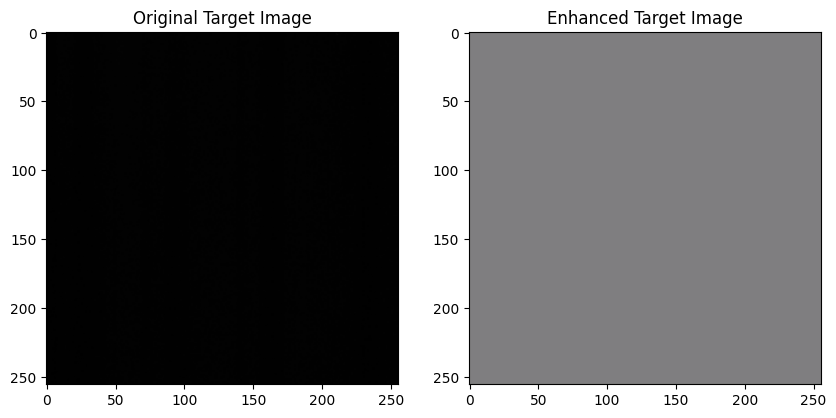

Model saved as 'enhanced_model.h5'.


In [ ]:
# import cv2
# import numpy as np
# import os
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, UpSampling2D, Attention
# from tensorflow.keras.models import Sequential, Model
# from tensorflow.keras.optimizers import Adam
# from skimage.metrics import structural_similarity as ssim

# # Define Dataset Paths
# ohrc_image_path = "/content/drive/MyDrive/data_sci/ohrc"
# iirs_image_path = "/content/drive/MyDrive/data_sci/iirs"
# output_dir = "/content/drive/MyDrive/data_sci/Output image"
# final_enhanced_dir = "/content/drive/MyDrive/data_sci/final_enhanced-image"
# os.makedirs(output_dir, exist_ok=True)
# os.makedirs(final_enhanced_dir, exist_ok=True)

# # 1. Image Preprocessing
# def preprocess_images(image_path, img_size=(256, 256)):
#     images = []
#     for file in os.listdir(image_path):
#         img = cv2.imread(os.path.join(image_path, file))
#         if img is not None:
#             img = cv2.resize(img, img_size)
#             img = img / 255.0  # Normalize to [0, 1]
#             images.append(img)
#     return np.array(images)

# # Load Images
# ohrc_images = preprocess_images(ohrc_image_path)
# iirs_images = preprocess_images(iirs_image_path)

# print("OHRC Images Shape:", ohrc_images.shape)
# print("IIRS Images Shape:", iirs_images.shape)

# # 2. Shared Encoder with Structural and Resolution Embeddings
# def build_shared_encoder(input_shape=(256, 256, 3)):
#     input_layer = Input(shape=input_shape)
#     x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
#     x = MaxPooling2D((2, 2))(x)
#     x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#     x = MaxPooling2D((2, 2))(x)

#     # Structural Embeddings
#     structural_branch = Flatten()(x)
#     structural_embedding = Dense(128, activation='relu', name="structural_embedding")(structural_branch)

#     # Resolution Embeddings
#     resolution_branch = Flatten()(x)
#     resolution_embedding = Dense(128, activation='relu', name="resolution_embedding")(resolution_branch)

#     model = Model(inputs=input_layer, outputs=[structural_embedding, resolution_embedding])
#     return model

# shared_encoder = build_shared_encoder()
# shared_encoder.summary()

# # 3. Attention Layer
# def attention_layer(inputs):
#     query, value = inputs
#     attn = Attention()([query, value])
#     return attn

# # 4. Generator and Discriminator
# def build_generator():
#     model = Sequential()
#     model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)))
#     model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
#     model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))  # Output: 3-channel image
#     return model

# def build_discriminator():
#     model = Sequential()
#     model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 6)))
#     model.add(MaxPooling2D((2, 2)))
#     model.add(Flatten())
#     model.add(Dense(1, activation='sigmoid'))  # Real or Fake
#     return model

# # Define and Compile Models
# generator = build_generator()
# discriminator = build_discriminator()

# discriminator.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

# def build_gan(generator, discriminator):
#     discriminator.trainable = False
#     gan_input = Input(shape=(256, 256, 3))
#     enhanced_image = generator(gan_input)
#     gan_output = discriminator(concatenate([gan_input, enhanced_image]))
#     gan = Model(inputs=gan_input, outputs=gan_output)
#     return gan

# gan = build_gan(generator, discriminator)
# gan.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy')

# print("Generator:")
# generator.summary()
# print("Discriminator:")
# discriminator.summary()

# # 5. Training Loop
# X = ohrc_images  # Input images
# Y = iirs_images  # Target images for conditional GAN

# epochs = 10
# batch_size = min(16, min(len(X), len(Y)))

# for epoch in range(epochs):
#     num_batches = len(X) // batch_size
#     epoch_d_loss, epoch_g_loss = 0, 0

#     for batch in range(num_batches):
#         start_idx = batch * batch_size
#         end_idx = start_idx + batch_size
#         real_images = X[start_idx:end_idx]
#         target_images = Y[start_idx:end_idx]

#         # Generate Fake Images
#         fake_images = generator.predict(real_images)

#         # Train Discriminator
#         real_labels = np.ones((batch_size, 1))
#         fake_labels = np.zeros((batch_size, 1))
#         d_loss_real = discriminator.train_on_batch(np.concatenate([real_images, target_images], axis=-1), real_labels)
#         d_loss_fake = discriminator.train_on_batch(np.concatenate([real_images, fake_images], axis=-1), fake_labels)
#         d_loss = 0.5 * (d_loss_real[0] + d_loss_fake[0])

#         # Train Generator
#         g_loss = gan.train_on_batch(real_images, real_labels)

#         # Extract the loss value from the list
#         epoch_g_loss += g_loss[0]  # Access the first element (loss)

#         epoch_d_loss += d_loss

#     print(f"Epoch {epoch+1}/{epochs} | D Loss: {epoch_d_loss/num_batches:.4f} | G Loss: {epoch_g_loss/num_batches:.4f}")

# # 6. Image Enhancement and Saving
# def enhance_image(image_path):
#     img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#     enhanced_img = clahe.apply(img)
#     return enhanced_img

# def save_images(images, output_dir, prefix="enhanced"):
#     for idx, img in enumerate(images):
#         img = (img * 255).astype('uint8')
#         save_path = os.path.join(output_dir, f"{prefix}_image_{idx+1}.png")
#         cv2.imwrite(save_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
#         print(f"Saved: {save_path}")

# enhanced_images = generator.predict(ohrc_images)
# save_images(enhanced_images, output_dir)

# for file in os.listdir(output_dir):
#     file_path = os.path.join(output_dir, file)
#     final_image = enhance_image(file_path)
#     save_path = os.path.join(final_enhanced_dir, file)
#     cv2.imwrite(save_path, final_image)
#     print(f"Saved Final Enhanced Image: {save_path}")

# # 7. Verification with Metrics
# def psnr(target, enhanced):
#     mse = np.mean((target - enhanced) ** 2)
#     if mse == 0:
#         return 100  # Maximum PSNR value
#     max_pixel = 1.0  # Since the images are normalized to [0, 1]
#     return 20 * np.log10(max_pixel / np.sqrt(mse))

# def ssim_metric(target, enhanced):
#     return ssim(target, enhanced, win_size=3, multichannel=True, data_range=1.0)  # Images normalized to [0,1]

# def evaluate_enhancement(target_images, enhanced_images):
#     psnr_values = []
#     ssim_values = []

#     for target, enhanced in zip(target_images, enhanced_images):
#         psnr_values.append(psnr(target, enhanced))
#         ssim_values.append(ssim_metric(target, enhanced))

#     avg_psnr = np.mean(psnr_values)
#     avg_ssim = np.mean(ssim_values)

#     print(f"Average PSNR: {avg_psnr:.4f}")
#     print(f"Average SSIM: {avg_ssim:.4f}")

# # Custom Target Image for Evaluation (Load your target image here)
# target_image_path = "/content/drive/MyDrive/data_sci/target/target01.tif"  # Replace with your target image path
# target_image = cv2.imread(target_image_path)  # Read the image
# target_image = cv2.resize(target_image, (256, 256)) / 255.0  # Resize and normalize
# enhanced_target_image = generator.predict(np.expand_dims(target_image, axis=0))  # Enhance

# # Display Original and Enhanced Image
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.title("Original Target Image")
# plt.imshow(target_image)
# plt.subplot(1, 2, 2)
# plt.title("Enhanced Target Image")
# plt.imshow(enhanced_target_image[0])
# plt.show()

# # 8. Save the Model
# generator.save("/content/drive/MyDrive/data_sci/enhanced_model.h5")
# print("Model saved as 'enhanced_model.h5'.")



In [ ]:
# 7. Verification with Metrics
def psnr(target, enhanced):
    mse = np.mean((target - enhanced) ** 2)
    if mse == 0:
        return 100  # Maximum PSNR value
    max_pixel = 1.0  # Since the images are normalized to [0, 1]
    return 20 * np.log10(max_pixel / np.sqrt(mse))

def ssim_metric(target, enhanced):
    return ssim(target, enhanced, win_size=3, multichannel=True, data_range=1.0)  # Images normalized to [0,1]

def evaluate_enhancement(target_images, enhanced_images):
    psnr_values = []
    ssim_values = []

    for target, enhanced in zip(target_images, enhanced_images):
        psnr_values.append(psnr(target, enhanced))
        ssim_values.append(ssim_metric(target, enhanced))

    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)

    print(f"Average PSNR: {avg_psnr:.4f}")
    print(f"Average SSIM: {avg_ssim:.4f}")

# Evaluate the enhanced images (in `final_enhanced_dir`)
enhanced_images = [cv2.imread(os.path.join(final_enhanced_dir, file)) for file in os.listdir(final_enhanced_dir)]
enhanced_images = [cv2.resize(img, (256, 256)) / 255.0 for img in enhanced_images]  # Normalize and resize
evaluate_enhancement(iirs_images, enhanced_images)

In [ ]:
import os


output_dir = "/content/drive/MyDrive/data_sci/Output image"                                                   #directory to store the output images
os.makedirs(output_dir, exist_ok=True)


def save_images(images, output_dir, prefix="enhanced"):                          # Saving the enhanced images to the output directory
    for idx, img in enumerate(images):
        img = (img * 255).astype('uint8')                                         # Convert back to 8-bit format
        save_path = os.path.join(output_dir, f"{prefix}_image_{idx+1}.png")
        cv2.imwrite(save_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))              # Convert to BGR for saving
        print(f"Saved: {save_path}")

# Generate and save enhanced images
enhanced_images = generator.predict(ohrc_images)                                  # Enhancing the OHRC images
save_images(enhanced_images, output_dir)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
Saved: /content/drive/MyDrive/data_sci/Output image/enhanced_image_1.png
Saved: /content/drive/MyDrive/data_sci/Output image/enhanced_image_2.png


In [ ]:
def enhance_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_img = clahe.apply(img)
    return enhanced_img



# Define the path to the denoised image directory
denoised_dir = "/content/drive/MyDrive/data_sci/target"

# Applying enhancement to denoised images
enhanced_dir = "final_enhanced_images"
os.makedirs(enhanced_dir, exist_ok=True)

for file in os.listdir(denoised_dir):
    file_path = os.path.join(denoised_dir, file)
    enhanced_img = enhance_image(file_path)
    save_path = os.path.join(enhanced_dir, f"final_{file}")
    cv2.imwrite(save_path, enhanced_img)
    print(f"Saved Final Enhanced Image: {save_path}")


Saved Final Enhanced Image: final_enhanced_images/final_target03.tif
Saved Final Enhanced Image: final_enhanced_images/final_target01.tif
Saved Final Enhanced Image: final_enhanced_images/final_target02.tif
Saved Final Enhanced Image: final_enhanced_images/final_enhanced_image_1.png
Saved Final Enhanced Image: final_enhanced_images/final_enhanced_image_2.png


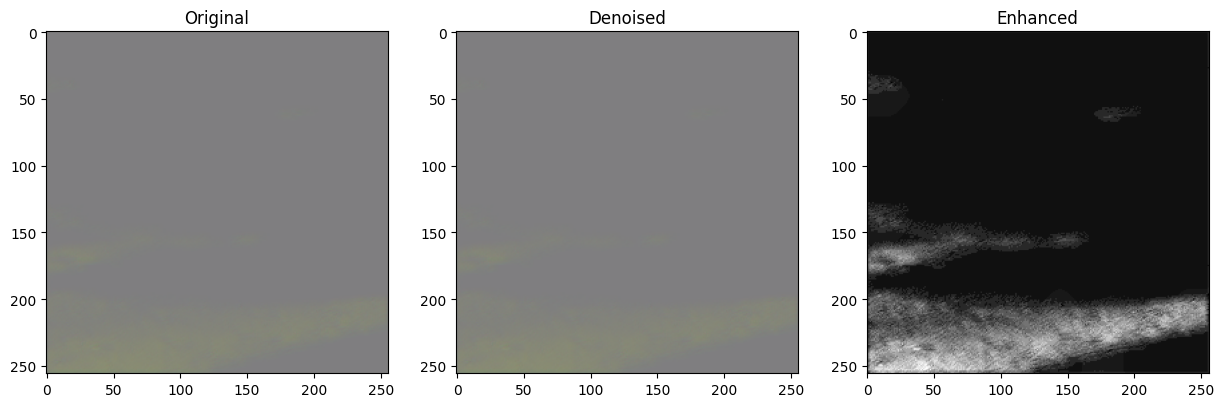

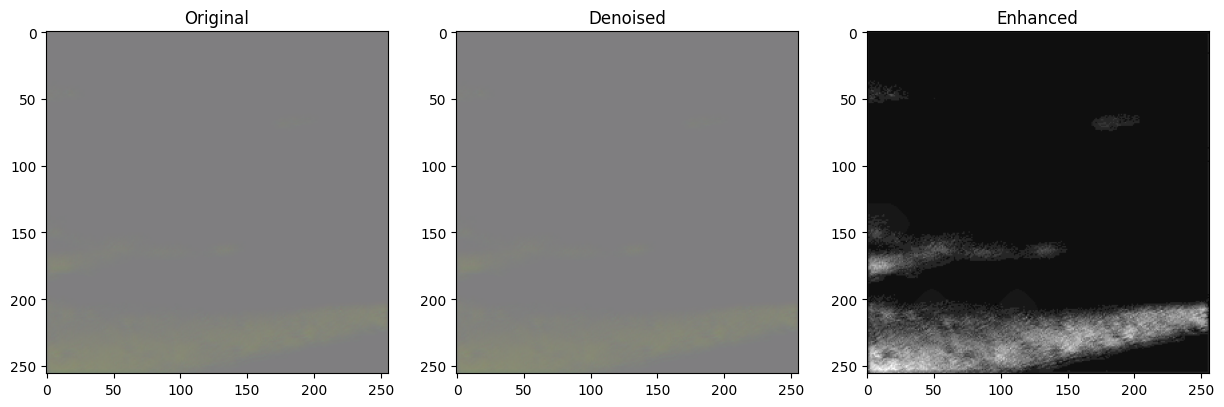

In [ ]:
# Visualize Original, Denoised, and Final Enhanced Images
def visualize_images(original_dir, denoised_dir, enhanced_dir, num_images=5):
    original_files = sorted(os.listdir(original_dir))[:num_images]
    denoised_files = sorted(os.listdir(denoised_dir))[:num_images]
    enhanced_files = sorted(os.listdir(enhanced_dir))[:num_images]

    for orig, denoised, enhanced in zip(original_files, denoised_files, enhanced_files):
        orig_img = cv2.imread(os.path.join(original_dir, orig))
        denoised_img = cv2.imread(os.path.join(denoised_dir, denoised))
        enhanced_img = cv2.imread(os.path.join(enhanced_dir, enhanced), cv2.IMREAD_GRAYSCALE)

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title("Original")
        plt.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
        plt.subplot(1, 3, 2)
        plt.title("Denoised")
        plt.imshow(cv2.cvtColor(denoised_img, cv2.COLOR_BGR2RGB))
        plt.subplot(1, 3, 3)
        plt.title("Enhanced")
        plt.imshow(enhanced_img, cmap='gray')
        plt.show()

visualize_images(output_dir, denoised_dir, enhanced_dir)


In [ ]:
import os


output_dir = "/content/drive/MyDrive/data_sci/Output image"                                                   #directory to store the output images
os.makedirs(output_dir, exist_ok=True)


def save_images(images, output_dir, prefix="enhanced"):                          # Saving the enhanced images to the output directory
    for idx, img in enumerate(images):
        img = (img * 255).astype('uint8')                                         # Convert back to 8-bit format
        save_path = os.path.join(output_dir, f"{prefix}_image_{idx+1}.png")
        cv2.imwrite(save_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))              # Convert to BGR for saving
        print(f"Saved: {save_path}")

# Generate and save enhanced images
enhanced_images = generator.predict(ohrc_images)                                  # Enhancing the OHRC images
save_images(enhanced_images, output_dir)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
Saved: /content/drive/MyDrive/data_sci/Output image/enhanced_image_1.png
Saved: /content/drive/MyDrive/data_sci/Output image/enhanced_image_2.png


# MODEL ACCURACY Define

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, UpSampling2D, Attention
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from skimage.metrics import structural_similarity as ssim

# Define Dataset Paths
ohrc_image_path = "/content/drive/MyDrive/data_sci/ohrc"
iirs_image_path = "/content/drive/MyDrive/data_sci/iirs"
output_dir = "/content/drive/MyDrive/data_sci/Output image"
final_enhanced_dir = "/content/drive/MyDrive/data_sci/final_enhanced-image"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(final_enhanced_dir, exist_ok=True)

# 1. Image Preprocessing
def preprocess_images(image_path, img_size=(256, 256)):
    images = []
    for file in os.listdir(image_path):
        img = cv2.imread(os.path.join(image_path, file))
        if img is not None:
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize to [0, 1]
            images.append(img)
    return np.array(images)

# Load Images
ohrc_images = preprocess_images(ohrc_image_path)
iirs_images = preprocess_images(iirs_image_path)

print("OHRC Images Shape:", ohrc_images.shape)
print("IIRS Images Shape:", iirs_images.shape)

# 2. Shared Encoder with Structural and Resolution Embeddings
def build_shared_encoder(input_shape=(256, 256, 3)):
    input_layer = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    # Structural Embeddings
    structural_branch = Flatten()(x)
    structural_embedding = Dense(128, activation='relu', name="structural_embedding")(structural_branch)

    # Resolution Embeddings
    resolution_branch = Flatten()(x)
    resolution_embedding = Dense(128, activation='relu', name="resolution_embedding")(resolution_branch)

    model = Model(inputs=input_layer, outputs=[structural_embedding, resolution_embedding])
    return model

shared_encoder = build_shared_encoder()
shared_encoder.summary()

# 3. Attention Layer
def attention_layer(inputs):
    query, value = inputs
    attn = Attention()([query, value])
    return attn

# 4. Generator and Discriminator
def build_generator():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))  # Output: 3-channel image
    return model

def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 6)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))  # Real or Fake
    return model

# Define and Compile Models
generator = build_generator()
discriminator = build_discriminator()

discriminator.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(256, 256, 3))
    enhanced_image = generator(gan_input)
    gan_output = discriminator(concatenate([gan_input, enhanced_image]))
    gan = Model(inputs=gan_input, outputs=gan_output)
    return gan

gan = build_gan(generator, discriminator)
gan.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy')

print("Generator:")
generator.summary()
print("Discriminator:")
discriminator.summary()

# 5. Training Loop
X = ohrc_images  # Input images
Y = iirs_images  # Target images for conditional GAN

epochs = 10
batch_size = min(16, min(len(X), len(Y)))

for epoch in range(epochs):
    num_batches = len(X) // batch_size
    epoch_d_loss, epoch_g_loss = 0, 0

    for batch in range(num_batches):
        start_idx = batch * batch_size
        end_idx = start_idx + batch_size
        real_images = X[start_idx:end_idx]
        target_images = Y[start_idx:end_idx]

        # Generate Fake Images
        fake_images = generator.predict(real_images)

        # Train Discriminator
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))
        d_loss_real = discriminator.train_on_batch(np.concatenate([real_images, target_images], axis=-1), real_labels)
        d_loss_fake = discriminator.train_on_batch(np.concatenate([real_images, fake_images], axis=-1), fake_labels)
        d_loss = 0.5 * (d_loss_real[0] + d_loss_fake[0])

        # Train Generator
        g_loss = gan.train_on_batch(real_images, real_labels)

        # Extract the loss value from the list
        epoch_g_loss += g_loss[0]  # Access the first element (loss)

        epoch_d_loss += d_loss

    print(f"Epoch {epoch+1}/{epochs} | D Loss: {epoch_d_loss/num_batches:.4f} | G Loss: {epoch_g_loss/num_batches:.4f}")

# 6. Image Enhancement and Saving
def enhance_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_img = clahe.apply(img)
    return enhanced_img

def save_images(images, output_dir, prefix="enhanced"):
    for idx, img in enumerate(images):
        img = (img * 255).astype('uint8')
        save_path = os.path.join(output_dir, f"{prefix}_image_{idx+1}.png")
        cv2.imwrite(save_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        print(f"Saved: {save_path}")

enhanced_images = generator.predict(ohrc_images)
save_images(enhanced_images, output_dir)

for file in os.listdir(output_dir):
    file_path = os.path.join(output_dir, file)
    final_image = enhance_image(file_path)
    save_path = os.path.join(final_enhanced_dir, file)
    cv2.imwrite(save_path, final_image)
    print(f"Saved Final Enhanced Image: {save_path}")

# 7. Verification with Metrics
def psnr(target, enhanced):
    mse = np.mean((target - enhanced) ** 2)
    if mse == 0:
        return 100  # Maximum PSNR value
    max_pixel = 1.0  # Since the images are normalized to [0, 1]
    return 20 * np.log10(max_pixel / np.sqrt(mse))

def ssim_metric(target, enhanced):
    return ssim(target, enhanced, win_size=3, multichannel=True, data_range=1.0)  # Images normalized to [0,1]

def evaluate_enhancement(target_images, enhanced_images):
    psnr_values = []
    ssim_values = []

    for target, enhanced in zip(target_images, enhanced_images):
        psnr_values.append(psnr(target, enhanced))
        ssim_values.append(ssim_metric(target, enhanced))

    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)

    print(f"Average PSNR: {avg_psnr:.4f}")
    print(f"Average SSIM: {avg_ssim:.4f}")

# Evaluate the enhanced images (in `final_enhanced_dir`)
enhanced_images = [cv2.imread(os.path.join(final_enhanced_dir, file)) for file in os.listdir(final_enhanced_dir)]
enhanced_images = [cv2.resize(img, (256, 256)) / 255.0 for img in enhanced_images]  # Normalize and resize
evaluate_enhancement(iirs_images, enhanced_images)

# 8. Save the Model
generator.save("/content/drive/MyDrive/data_sci/enhanced_model.h5")
print("Model saved as 'enhanced_model.h5'.")


OHRC Images Shape: (2, 256, 256, 3)
IIRS Images Shape: (3, 256, 256, 3)


Model: "functional_111"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_48            │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_92 (Conv2D)        │ (None, 256, 256, 32)   │            896 │ input_layer_48[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_42          │ (None, 128, 128, 32)   │              0 │ conv2d_92[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_93 (Conv2D)        │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d_42[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_43          │ (None, 64, 64, 64)     │              0 │ conv2d_93[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_32 (Flatten)      │ (None, 262144)         │              0 │ max_pooling2d_43[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_33 (Flatten)      │ (None, 262144)         │              0 │ max_pooling2d_43[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ structural_embedding      │ (None, 128)            │     33,554,560 │ flatten_32[0][0]       │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resolution_embedding      │ (None, 128)            │     33,554,560 │ flatten_33[0][0]       │
│ (Dense)                   │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 67,128,512 (256.07 MB)

 Trainable params: 67,128,512 (256.07 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Generator:


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_94 (Conv2D)                   │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_95 (Conv2D)                   │ (None, 256, 256, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_96 (Conv2D)                   │ (None, 256, 256, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,123 (82.51 KB)

 Trainable params: 21,123 (82.51 KB)

 Non-trainable params: 0 (0.00 B)

Discriminator:


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_97 (Conv2D)                   │ (None, 256, 256, 64)        │           3,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_44 (MaxPooling2D)      │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_34 (Flatten)                 │ (None, 1048576)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │       1,048,577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,052,097 (4.01 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,052,097 (4.01 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 1/10 | D Loss: 0.6771 | G Loss: 0.7049
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Epoch 2/10 | D Loss: 0.6957 | G Loss: 0.7050
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
Epoch 3/10 | D Loss: 0.6995 | G Loss: 0.7051
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
Epoch 4/10 | D Loss: 0.7012 | G Loss: 0.7052
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Epoch 5/10 | D Loss: 0.7021 | G Loss: 0.7053
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Epoch 6/10 | D Loss: 0.7028 | G Loss: 0.7054
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Epoch 7/10 | D Loss: 0.7033 | G Loss: 0.7055
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Epoch 8/10 | D Loss: 0.7037 | G Loss: 0.7056
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Epoch 9/10 | D Loss: 0.7040 | G Loss: 0.7057
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
Epoch 10/10 | D Loss: 0.7042 | G Loss: 0.7058
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


Saved: /content/drive/MyDrive/data_sci/Output image/enhanced_image_1.png
Saved: /content/drive/MyDrive/data_sci/Output image/enhanced_image_2.png
Saved Final Enhanced Image: /content/drive/MyDrive/data_sci/final_enhanced-image/enhanced_image_1.png
Saved Final Enhanced Image: /content/drive/MyDrive/data_sci/final_enhanced-image/enhanced_image_2.png
Average PSNR: 9.8734
Average SSIM: 0.1798
Model saved as 'enhanced_model.h5'.


# u net

In [ ]:
import cv2
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, UpSampling2D, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
from tensorflow.keras import backend as K
from skimage.metrics import structural_similarity as ssim

# Define Dataset Paths
ohrc_image_path = "/content/drive/MyDrive/data_sci/ohrc"
iirs_image_path = "/content/drive/MyDrive/data_sci/iirs"
output_dir = "/content/drive/MyDrive/data_sci/Output image"
final_enhanced_dir = "/content/drive/MyDrive/data_sci/final_enhanced-image"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(final_enhanced_dir, exist_ok=True)

# 1. Image Preprocessing
def preprocess_images(image_path, img_size=(256, 256)):
    images = []
    for file in os.listdir(image_path):
        img = cv2.imread(os.path.join(image_path, file))
        if img is not None:
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize to [0, 1]
            images.append(img)
    return np.array(images)

# Load Images
ohrc_images = preprocess_images(ohrc_image_path)
iirs_images = preprocess_images(iirs_image_path)

print("OHRC Images Shape:", ohrc_images.shape)
print("IIRS Images Shape:", iirs_images.shape)

# 2. U-Net Architecture for Image Enhancement
def build_unet(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)

    # Contracting path
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Expansive path
    u5 = UpSampling2D((2, 2))(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs, outputs)
    return model

# Build and Compile Model
unet_model = build_unet()
unet_model.compile(optimizer=Adam(learning_rate=0.0002), loss='mse')

# 3. Perceptual Loss (VGG19 Feature Extraction)
# Create the VGG19 model outside the perceptual_loss function
vgg = VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
vgg.trainable = False
vgg_model = Model(inputs=vgg.input, outputs=vgg.output)

def perceptual_loss(y_true, y_pred):
    # Extract features for perceptual loss using the pre-created vgg_model
    feature_true = vgg_model(y_true)
    feature_pred = vgg_model(y_pred)

    return K.mean(K.square(feature_true - feature_pred))

# Custom Loss Function: Combine MSE and Perceptual Loss
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_true - y_pred))
    p_loss = perceptual_loss(y_true, y_pred)
    return mse_loss + 0.001 * p_loss  # Balance both losses

unet_model.compile(optimizer=Adam(learning_rate=0.0002), loss=custom_loss)

# 4. Training Loop
# 4. Training Loop
epochs = 30
batch_size = 16  # Or a value smaller than or equal to len(ohrc_images)

for epoch in range(epochs):
    num_batches = len(ohrc_images) // batch_size

    # If num_batches is 0, adjust the batch size
    if num_batches == 0:
        batch_size = len(ohrc_images)  # Set batch size to the number of images
        num_batches = 1  # There will be only one batch

    epoch_loss = 0

    for batch in range(num_batches):
        start_idx = batch * batch_size
        end_idx = start_idx + batch_size
        real_images = ohrc_images[start_idx:end_idx]
        target_images = iirs_images[start_idx:end_idx]

        # Train U-Net
        loss = unet_model.train_on_batch(real_images, target_images)
        epoch_loss += loss

    print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss/num_batches:.4f}")

# 5. Image Enhancement and Saving
def enhance_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_img = clahe.apply(img)
    return enhanced_img

def save_images(images, output_dir, prefix="enhanced"):
    for idx, img in enumerate(images):
        img = (img * 255).astype('uint8')
        save_path = os.path.join(output_dir, f"{prefix}_image_{idx+1}.png")
        cv2.imwrite(save_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        print(f"Saved: {save_path}")

# Save Enhanced Images
enhanced_images = unet_model.predict(ohrc_images)
save_images(enhanced_images, output_dir)

# 6. Verification with Metrics
def psnr(target, enhanced):
    mse = np.mean((target - enhanced) ** 2)
    if mse == 0:
        return 100
    max_pixel = 1.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))

def ssim_metric(target, enhanced):
    return ssim(target, enhanced, win_size=3, multichannel=True, data_range=1.0)

def evaluate_enhancement(target_images, enhanced_images):
    psnr_values = []
    ssim_values = []

    for target, enhanced in zip(target_images, enhanced_images):
        psnr_values.append(psnr(target, enhanced))
        ssim_values.append(ssim_metric(target, enhanced))

    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)

    print(f"Average PSNR: {avg_psnr:.4f}")
    print(f"Average SSIM: {avg_ssim:.4f}")

evaluate_enhancement(iirs_images, enhanced_images)

# 7. Save the Model
unet_model.save("/content/drive/MyDrive/data_sci/enhanced_unet_model.h5")
print("Model saved as 'enhanced_unet_model.h5'.")


OHRC Images Shape: (2, 256, 256, 3)
IIRS Images Shape: (3, 256, 256, 3)
Epoch 1/30 | Loss: 0.0935
Epoch 2/30 | Loss: 0.0931
Epoch 3/30 | Loss: 0.0925
Epoch 4/30 | Loss: 0.0916
Epoch 5/30 | Loss: 0.0900
Epoch 6/30 | Loss: 0.0870
Epoch 7/30 | Loss: 0.0820
Epoch 8/30 | Loss: 0.0757
Epoch 9/30 | Loss: 0.0713
Epoch 10/30 | Loss: 0.0684
Epoch 11/30 | Loss: 0.0654
Epoch 12/30 | Loss: 0.0622
Epoch 13/30 | Loss: 0.0594
Epoch 14/30 | Loss: 0.0573
Epoch 15/30 | Loss: 0.0556
Epoch 16/30 | Loss: 0.0541
Epoch 17/30 | Loss: 0.0526
Epoch 18/30 | Loss: 0.0512
Epoch 19/30 | Loss: 0.0498
Epoch 20/30 | Loss: 0.0486
Epoch 21/30 | Loss: 0.0476
Epoch 22/30 | Loss: 0.0467
Epoch 23/30 | Loss: 0.0458
Epoch 24/30 | Loss: 0.0449
Epoch 25/30 | Loss: 0.0441
Epoch 26/30 | Loss: 0.0433
Epoch 27/30 | Loss: 0.0427
Epoch 28/30 | Loss: 0.0420
Epoch 29/30 | Loss: 0.0414
Epoch 30/30 | Loss: 0.0408
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Saved: /content/drive/MyDrive/data_sci/Output image/enhanced_image_1.png
Saved: /content/drive/MyDrive/data_sci/Output image/enhanced_image_2.png
Average PSNR: 16.3557
Average SSIM: 0.2018
Model saved as 'enhanced_unet_model.h5'.
